In [1]:
!pip install gdsfactory
#==7.25.2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.0/663.0 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.5/232.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.1 MB/s eta 0:00:00
   ━━━━

### Import dependencies

In [2]:
import gdsfactory as gf
from gdsfactory.cross_section import cross_section
from gdsfactory.components import bend_euler, straight, taper
import numpy as np
import uuid

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
%cd /content/drive/Shareddrives/CMNS-phys-hafezi-lab/14 Topological photonics design/Supra design

/content/drive/Shareddrives/CMNS-phys-hafezi-lab/14 Topological photonics design/Supra design


## Define functions

### Single ring with euler bend


In [20]:
@gf.cell
def ring_resonator_euler(
    length_x: float,
    length_y: float,
    width: float,
    radius: float
) -> gf.Component:
    """Returns a fully closed ring resonator with Euler bends.

    Args:
        length_x: length of horizontal straight waveguides (x-direction)
        length_y: length of vertical straight waveguides (y-direction)
        width: waveguide width
        radius: Euler bend radius
    """
    c = gf.Component()
    xs = cross_section(width=width, layer=(1, 0))

    # Components
    bend = bend_euler(radius=radius, cross_section=xs)
    straight_x = straight(length=length_x, cross_section=xs)
    straight_y = straight(length=length_y, cross_section=xs)

    # Bottom-right bend
    b1 = c << bend

    # Right vertical straight
    s1 = c << straight_y
    s1.connect("o1", b1.ports["o2"])

    # Top-right bend
    b2 = c << bend
    b2.connect("o1", s1.ports["o2"])

    # Top horizontal straight
    s2 = c << straight_x
    s2.rotate(90)
    s2.connect("o1", b2.ports["o2"])

    # Top-left bend
    b3 = c << bend
    b3.rotate(180)
    b3.connect("o1", s2.ports["o2"])

    # Left vertical straight
    s3 = c << straight_y
    s3.mirror()
    s3.connect("o1", b3.ports["o2"])

    # Bottom-left bend
    b4 = c << bend
    b4.rotate(-90)
    b4.connect("o1", s3.ports["o2"])

    # Bottom horizontal straight (final segment to close the loop)
    s4 = c << straight_x
    s4.rotate(-90)
    s4.connect("o1", b4.ports["o2"])

    # Now s4 should end at the starting point of b1
    # Add port for loop start and end for visual/debugging
    c.add_port("loop_start", port=b1.ports["o1"])
    c.add_port("loop_closed", port=s4.ports["o2"])

    return c

2025-09-16 14:58:28.708 | WARNING  | kfactory.kcell:show:3909 - Could not connect to klive server


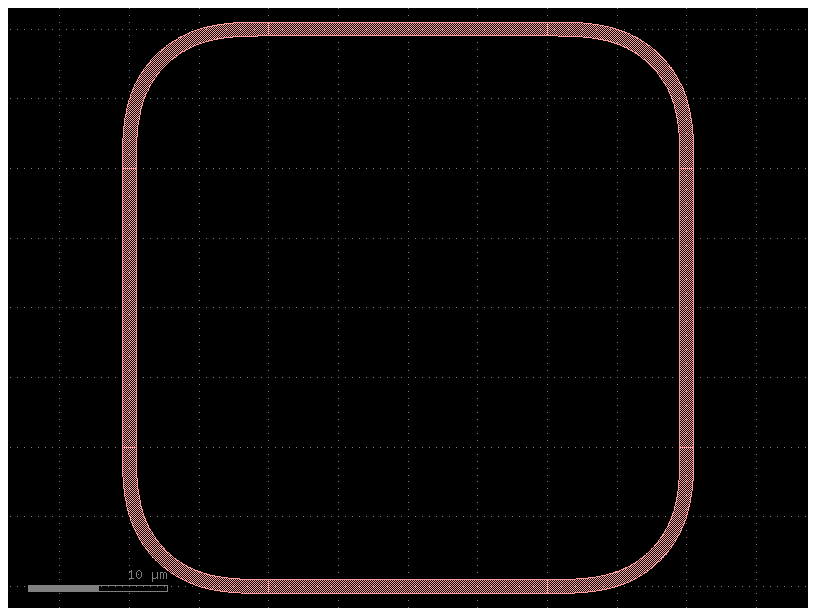

In [21]:
if __name__ == "__main__":
    ring = ring_resonator_euler(length_x=20, length_y=20, width=1, radius=10)
    ring.show()
    ring.plot()

## Input output coupler 1

In [22]:
@gf.cell
def io_Coupler_1(L, width, radius, taper_length, period, arcwidth, taper_angle, n_periods):

    x1 = cross_section(width=width, layer=(1, 0))

    c1 = gf.Component(name=f"io_Coupler_1_L{L}_w{width}_r{radius}_{uuid.uuid4().hex[:6]}")

    s = gf.components.straight(length=L, cross_section=x1)
    b = gf.components.bend_euler(radius=radius, cross_section=x1)

    fill_factor = arcwidth / period

    # Straight waveguide sections

    s1 = c1 << s
    s2 = c1 << s
    s3 = c1 << s
    s4 = c1 << s
    s5 = c1 << s

    # Euler bends

    b1 = c1 << b
    b2 = c1 << b
    b3 = c1 << b
    b4 = c1 << b

    # Connect the straight parts and euler bends

    b1.connect("o2", s1.ports["o2"])
    b2.connect("o1", s1.ports["o1"])
    s2.connect("o1", b2.ports["o2"])
    s3.connect("o1", b1.ports["o1"])
    b3.connect("o1", s3.ports["o2"])
    b4.connect("o2", s2.ports["o2"])
    s4.connect("o1", b3.ports["o2"])
    s5.connect("o2", b4.ports["o1"])

    xs = gf.cross_section.strip(width=width)
    grating = gf.components.grating_coupler_elliptical_uniform(cross_section=xs,
                                                           taper_length=taper_length,
                                                           taper_angle=taper_angle,
                                                           spiked=False,
                                                           layer_slab=None,
                                                           period=period,
                                                           n_periods=n_periods,
                                                           fill_factor=fill_factor)

    grat1 = c1 << grating
    grat2 = c1 << grating

    grat1.connect("o1", s5.ports["o1"], allow_width_mismatch=True)
    grat2.connect("o1", s4.ports["o2"], allow_width_mismatch=True)

    return c1

2025-09-16 14:58:29.807 | WARNING  | kfactory.kcell:show:3909 - Could not connect to klive server


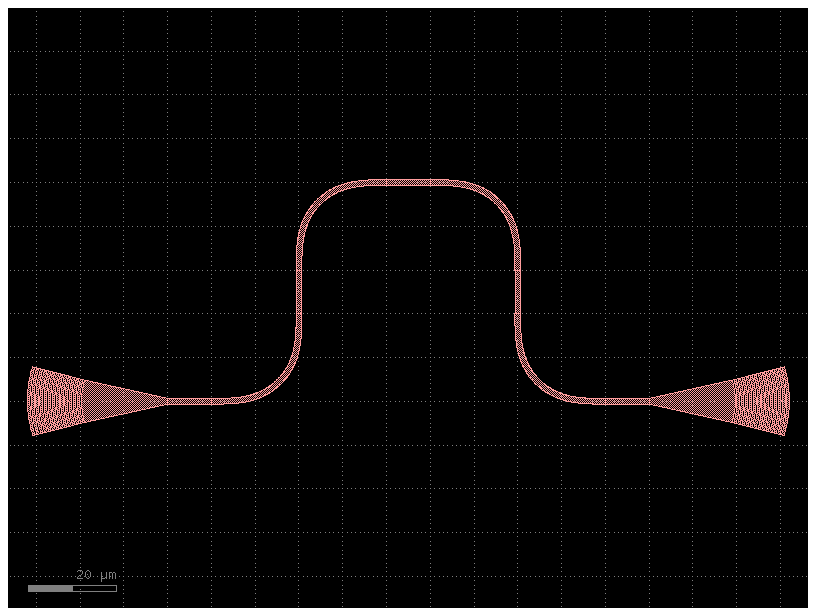

In [23]:
if __name__ == "__main__":
    io1 = io_Coupler_1(L=10, width=1.3, radius=20, taper_length=20, period=0.57+0.38, arcwidth=0.57, taper_angle=2*17, n_periods=13)
    io1.show()
    io1.plot()

## Input output coupler 2

In [24]:
@gf.cell
def io_Coupler_2(L, width, radius, taper_length, period, arcwidth, taper_angle, n_periods):

    x1 = cross_section(width=width, layer=(1, 0))

    c1 = gf.Component(name=f"io_Coupler_2_L{L}_w{width}_r{radius}_{uuid.uuid4().hex[:6]}")

    delta = 50
    wg_length = 10

    fill_factor = arcwidth/period

    s = gf.components.straight(length=L, cross_section=x1)
    sb = gf.components.straight(length=wg_length, cross_section=x1)
    sbig = gf.components.straight(length=L+delta, cross_section=x1)
    sbigt = gf.components.straight(length=L+radius*2+wg_length, cross_section=x1)

    b = gf.components.bend_euler(radius=radius, cross_section=x1)

    # Straight waveguides

    s1=c1 << s
    s2=c1 << s
    s3=c1 << sb
    sbig1 = c1 << sbig
    sbig2 = c1 << sbigt

    # Euler bends

    b1 = c1 << b
    b2 = c1 << b
    b3 = c1 << b
    b4 = c1 << b

    # Connect straight sections to bends

    s1.connect("o2", b1.ports["o2"])
    s2.connect("o1", b1.ports["o1"])
    b2.connect("o2", s2.ports["o2"])
    sbig1.connect("o1", b2.ports["o1"])
    b3.connect("o2", sbig1.ports["o2"])
    sbig2.connect("o2", b3.ports["o1"])
    b4.connect("o2", s1.ports["o1"])
    s3.connect("o2", b4.ports["o1"])

    xs = gf.cross_section.strip(width=width)
    grating = gf.components.grating_coupler_elliptical_uniform(cross_section=xs,
                                                               taper_length=taper_length,
                                                               taper_angle=taper_angle,
                                                               spiked=False,
                                                               layer_slab=None,
                                                               period=period,
                                                               n_periods=n_periods,
                                                               fill_factor=fill_factor)

    grat1 = c1 << grating
    grat2 = c1 << grating

    grat1.connect("o1", s3.ports["o1"], allow_width_mismatch=True)
    grat2.connect("o1", sbig2.ports["o1"], allow_width_mismatch=True)

    return c1

2025-09-16 14:58:30.832 | WARNING  | kfactory.kcell:show:3909 - Could not connect to klive server


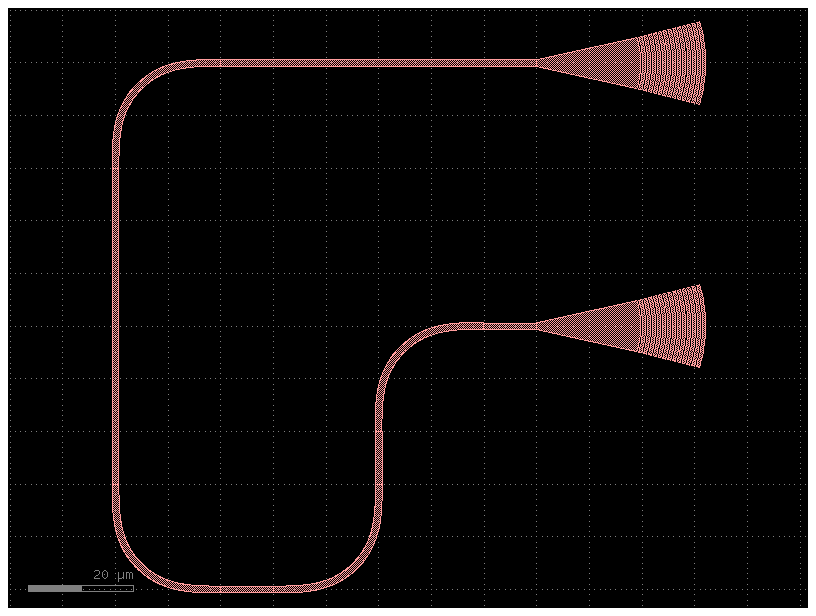

In [25]:
if __name__ == "__main__":
    io2 = io_Coupler_2(L=10, width=1.3, radius=20, taper_length=20, period=0.57+0.38, arcwidth=0.57, taper_angle=2*17, n_periods=13)
    io2.show()
    io2.plot()

## Add drop filter - chain of rings

In [26]:
@gf.cell
def ring_chain(radius, L, width, latticeX, latticeY, N, gap):
    """Returns chain of rings.

    Args:
        radius: Euler bend radius
        L: length of straight section of racetrack
        width: waveguide width
        latticeX: x position of lattice
        latticeY: y position of lattice
        N: lattice size (>=1)
        gap: gap between rings
    """
    c = gf.Component(name=f"chain_{uuid.uuid4().hex[:6]}")

    if N == 1:
      shiftX = 0
    else:
      shiftX = 2 * radius + L + width + gap
    shiftY = 2 * radius + L + width + gap

    for i in range(0, N):
        xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
        xref.move([(latticeX), (latticeY + i * shiftY)])

    # Grating parameters

    L_coupler = L
    radius_grating = 20
    taper_length = 20
    period = 0.57 + 0.38
    aW = 0.57
    taper_angle = 2*17
    n_periods = 13

    wr1 = c << io_Coupler_1(L_coupler, width, radius_grating, taper_length, period, aW, taper_angle, n_periods)
    wr2 = c << io_Coupler_2(L_coupler, width, radius_grating, taper_length, period, aW, taper_angle, n_periods)
    wr1.move([latticeX - L , latticeY - gap - width])
    wr2.move([latticeX, latticeY + L + 2 * radius + (N-1) * (2 * radius + L + gap + width) + gap + width])

    return c

2025-09-16 14:58:32.385 | WARNING  | kfactory.kcell:show:3909 - Could not connect to klive server


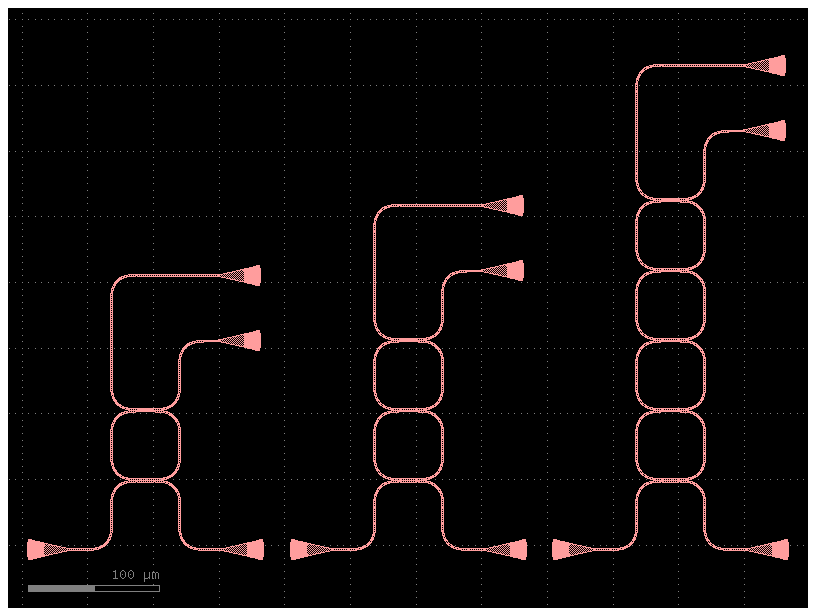

In [27]:
gf.clear_cache()
chain = gf.Component("chain")

x_shift = 200
chain << ring_chain(20, 12, 1.2, 0, 0, 1, 0.2)
chain << ring_chain(20, 12, 1.2, x_shift, 0, 2, 0.2)
chain << ring_chain(20, 12, 1.2, 2 * x_shift, 0, 4, 0.2)
chain.show()
chain.plot()

## AQHE / IQHE lattice

In [28]:
@gf.cell
def topo_lattice(topology, radius, L, xi, alpha, width, latticeX, latticeY, N, gap, fc_gap):
  """Returns AQHE or IQHE lattice.

    Args:
        topology: topology of lattice (IQHE or AQHE)
        radius: Euler bend radius
        L: length of straight section of racetrack
        xi: odd row link rings get extra shift xi each column
        alpha: x-dimension of link-ring is longer than L by alpha
        width: waveguide width
        latticeX: x position of lattice
        latticeY: y position of lattice
        N: lattice size
        gap: gap between rings
        fc_gap: gap between ring and i/o fiber coupler
    """
  c = gf.Component(name=f"QHE_{uuid.uuid4().hex[:6]}")

  shiftX = 2 * radius + L + width + gap + alpha/2 #compensate for the longer link rings
  shiftY = 2 * radius + L + width + gap

  xi = xi/2

  if topology == "IQHE":
    var_topology = 0
  elif topology == "AQHE":
    var_topology = 1
  else:
    raise ValueError("Topology must be IQHE or AQHE")

  for i in range(0, 2 * N - 1):
      for j in range(0, 2 * N - 1):
          if(var_topology == 0): ## IQHE
              #LINK RING LOOP - X LENGTH IS INCREASED BY ALPHA
              if((i%2 == 1) ^ (j%2 == 1)):
                if(j%2 == 0): #ODD ROW LINK RINGS GET EXTRA SHIFT XI EACH COLUMN
                  xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
                  xref.move([(latticeX + j * (shiftX + xi) + alpha/2), (latticeY + i * shiftY)])
                else: #EVEN ROW LINK RINGS ARE IN LINE WITH SITE RINGS AND GET NO EXTRA SHIFT
                  xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
                  xref.move([(latticeX + j * shiftX + alpha/2), (latticeY + i * shiftY)])
              elif((i%2 == 0) and (j%2 == 0)):
                xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
                xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])
          elif(var_topology == 1):  ## AQHE
              #LINK RING LOOP - X LENGTH IS INCREASED BY ALPHA
              if((i%2 == 1) and (j%2 == 1)):
                #ODD ROW LINK RINGS GET EXTRA SHIFT XI EACH COLUMN
                xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
                xref.move([(latticeX + j * (shiftX + 0) + alpha/2), (latticeY + i * shiftY)])
                #EVEN ROW LINK RINGS ARE IN LINE WITH SITE RINGS AND GET NO EXTRA SHIFT
              #SITE RINGS, NO EXTRA LENGTH OR SHIFT
              if((i%2 == 1) and (j%2 == 0)):
                xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
                xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])
              elif((i%2 == 0) and (j%2 == 1)):
                xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
                xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])


  # Grating parameters

  L_coupler = 10
  radius_grating = 20
  taper_length = 20
  period = 0.57 + 0.38
  aW = 0.57
  taper_angle = 2*17
  n_periods = 13

  wr1 = c << io_Coupler_1(L_coupler, width, radius_grating, taper_length, period, aW, taper_angle, n_periods)
  wr2 = c << io_Coupler_2(L_coupler, width, radius_grating, taper_length, period, aW, taper_angle, n_periods)
  wr1.move([latticeX - L + var_topology*(2 * radius + L + gap + width), latticeY - fc_gap - width])
  wr2.move([latticeX + var_topology*(2 * radius + L + gap + width), latticeY + L + 2 * radius + 2 * (N-1) * (2 * radius + L + gap + width) + fc_gap + width])

  return c

2025-09-16 14:58:33.172 | WARNING  | kfactory.kcell:show:3909 - Could not connect to klive server


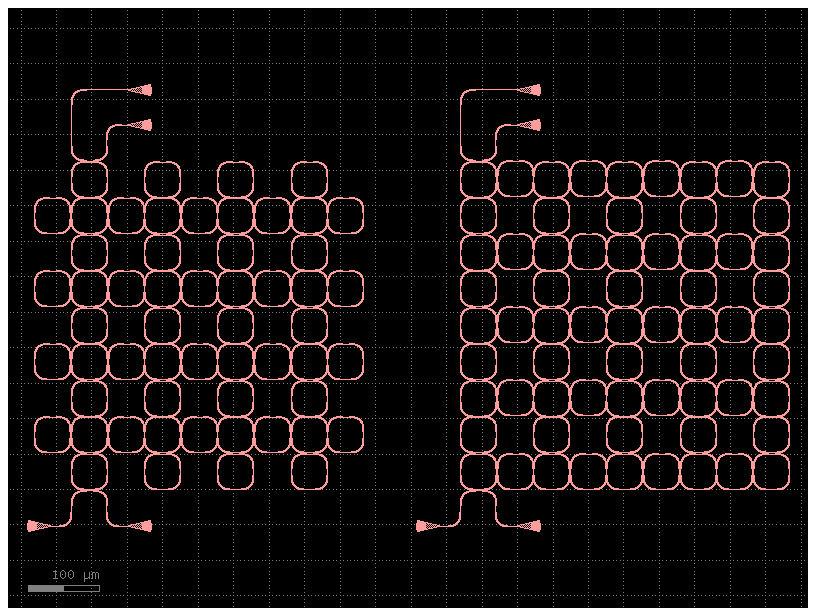

In [29]:
gf.clear_cache()
qhe = gf.Component("qhe")

x_shift = 600

qhe << topo_lattice("AQHE", 20, 10, 0, 0.2, 1.3, 0, 0, 5, 0.2, 0.2)
qhe << topo_lattice("IQHE", 20, 10, 0, 0.2, 1.3, x_shift, 0, 5, 0.2, 0.2)
qhe.show()
qhe.plot()

## IQHE - ring of rings

In [30]:
@gf.cell
def IQHE_ROR(radius, L, xi, alpha, width, latticeX, latticeY, N, N_edge, gap, fc_gap):
  """Returns IQHE lattice.

    Args:
        radius: Euler bend radius
        L: length of straight section of racetrack
        xi: odd row link rings get extra shift xi each column
        alpha: x-dimension of link-ring is longer than L by alpha
        width: waveguide width
        latticeX: #columns in chip
        latticeY: #rows in chip
        N: lattice size
        N_edge: thickness of edge in # of plaquettes (>=0)
        gap: gap between rings
        fc_gap: gap between ring and i/o fiber coupler
    """
  c = gf.Component(name=f"IQHE_{uuid.uuid4().hex[:6]}")

  for i in range(0, (2 * N_edge + 1)):
      for j in range(0, 2 * N - 1):
        shiftX = 2 * radius + L + width + gap + alpha/2 #compensate for the longer link rings
        shiftY = 2 * radius + L + width + gap

        ### LINK RING LOOP - X LENGTH IS INCREASED BY ALPHA
        if((i%2 == 1) ^ (j%2 == 1)):
          if(j%2 == 0): #ODD ROW LINK RINGS GET EXTRA SHIFT XI EACH COLUMN
            xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
            xref.move([(latticeX + j * (shiftX + xi) + alpha/2),(latticeY + i * shiftY)])
          else: #EVEN ROW LINK RINGS ARE IN LINE WITH SITE RINGS AND GET NO EXTRA SHIFT
            xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
            xref.move([(latticeX + j * shiftX + alpha/2),(latticeY + i * shiftY)])
        elif((i%2 == 0) and (j%2 == 0)):
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
          xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])


  for i in range(2 * N - 1 - (2 * N_edge + 1), 2 * N - 1):
      for j in range(0, 2 * N - 1):
        shiftX = 2 * radius + L + width + gap + alpha/2 #compensate for the longer link rings
        shiftY = 2 * radius + L + width + gap

        ### LINK RING LOOP - X LENGTH IS INCREASED BY ALPHA
        if((i%2 == 1) ^ (j%2 == 1)):
          if(j%2 == 0): #ODD ROW LINK RINGS GET EXTRA SHIFT XI EACH COLUMN
            xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
            xref.move([(latticeX + j * (shiftX + xi) + alpha/2),(latticeY + i * shiftY)])
          else: #EVEN ROW LINK RINGS ARE IN LINE WITH SITE RINGS AND GET NO EXTRA SHIFT
            xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
            xref.move([(latticeX + j * shiftX + alpha/2),(latticeY + i * shiftY)])
        elif((i%2 == 0) and (j%2 == 0)):
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
          xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])


  for i in range(0, 2 * N - 1):
      for j in range(0, (2 * N_edge + 1)):
        shiftX = 2 * radius + L + width + gap + alpha/2 #compensate for the longer link rings
        shiftY = 2 * radius + L + width + gap

        ### LINK RING LOOP - X LENGTH IS INCREASED BY ALPHA
        if((i%2 == 1) ^ (j%2 == 1)):
          if(j%2 == 0): #ODD ROW LINK RINGS GET EXTRA SHIFT XI EACH COLUMN
            xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
            xref.move([(latticeX + j * (shiftX + xi) + alpha/2),(latticeY + i * shiftY)])
          else: #EVEN ROW LINK RINGS ARE IN LINE WITH SITE RINGS AND GET NO EXTRA SHIFT
            xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
            xref.move([(latticeX + j * shiftX + alpha/2),(latticeY + i * shiftY)])
        elif((i%2 == 0) and (j%2 == 0)):
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
          xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])


  for i in range(0, 2 * N - 1):
      for j in range(2 * N - 1 - (2 * N_edge + 1), 2 * N - 1):
        shiftX = 2 * radius + L + width + gap + alpha/2 #compensate for the longer link rings
        shiftY = 2 * radius + L + width + gap

        ### LINK RING LOOP - X LENGTH IS INCREASED BY ALPHA
        if((i%2 == 1) ^ (j%2 == 1)):
          if(j%2 == 0): #ODD ROW LINK RINGS GET EXTRA SHIFT XI EACH COLUMN
            xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
            xref.move([(latticeX + j * (shiftX + xi) + alpha/2),(latticeY + i * shiftY)])
          else: #EVEN ROW LINK RINGS ARE IN LINE WITH SITE RINGS AND GET NO EXTRA SHIFT
            xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
            xref.move([(latticeX + j * shiftX + alpha/2),(latticeY + i * shiftY)])
        elif((i%2 == 0) and (j%2 == 0)):
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
          xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])


  # Grating parameters

  L_coupler = 10
  radius_grating = 20
  taper_length = 20
  period = 0.57 + 0.38
  aW = 0.57
  taper_angle = 2*17
  n_periods = 13

  wr1 = c << io_Coupler_1(L_coupler, width, radius_grating, taper_length, period, aW, taper_angle, n_periods)
  wr2 = c << io_Coupler_2(L_coupler, width, radius_grating, taper_length, period, aW, taper_angle, n_periods)
  wr1.move([latticeX - L, latticeY - fc_gap - width])
  wr2.move([latticeX, latticeY + L + 2 * radius + 2 * (N-1) * (2 * radius + L + gap + width) + fc_gap + width])

  return c

2025-09-16 14:58:34.608 | WARNING  | kfactory.kcell:show:3909 - Could not connect to klive server


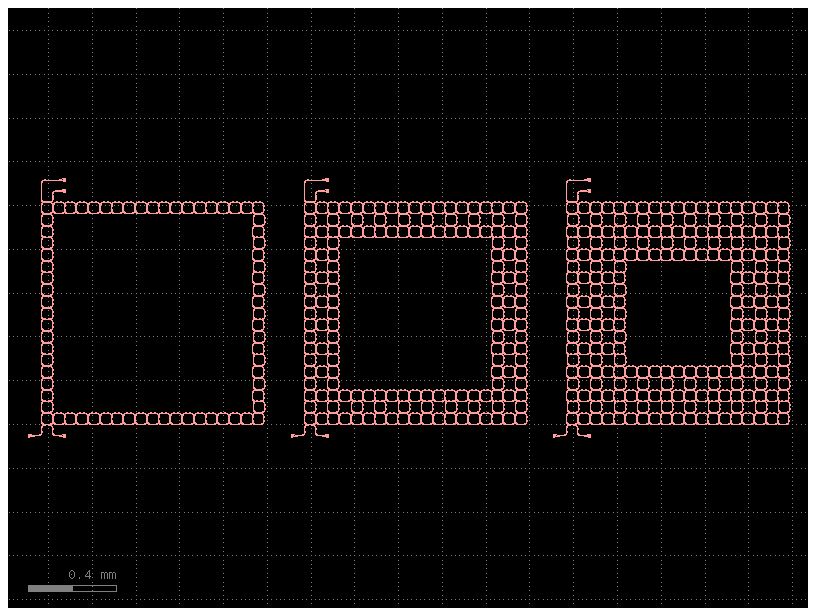

In [31]:
gf.clear_cache()
iqhe_ror = gf.Component("iqhe_ror")

x_shift = 1200

iqhe_ror << IQHE_ROR(20, 12, 0.1, 0.2, 1.3, 0, 0, 10, 0, 0.2, 0.2)
iqhe_ror << IQHE_ROR(20, 12, 0.1, 0.2, 1.3, x_shift, 0, 10, 1, 0.2, 0.2)
iqhe_ror << IQHE_ROR(20, 12, 0.1, 0.2, 1.3, 2*x_shift, 0, 10, 2, 0.2, 0.2)
iqhe_ror.show()
iqhe_ror.plot()

## AQHE - ring of rings

In [32]:
@gf.cell
def AQHE_ROR(radius, L, xi, alpha, width, latticeX, latticeY, N, N_edge, gap, fc_gap):
  """Returns AQHE lattice.

    Args:
        radius: Euler bend radius
        L: length of straight section of racetrack
        xi: odd row link rings get extra shift xi each column
        alpha: x-dimension of link-ring is longer than L by alpha
        width: waveguide width
        latticeX: #columns in chip
        latticeY: #rows in chip
        N: lattice size
        N_edge: thickness of edge in # of plaquettes
        gap: gap between rings
        fc_gap: gap between ring and i/o fiber coupler
    """
  c = gf.Component(name=f"AQHE_{uuid.uuid4().hex[:6]}")

### Bottom row
  for i in range(0, (2 * N_edge + 1)):
      for j in range(0, 2 * N - 1):
        shiftX = 2 * radius + L + width + gap + alpha/2 #compensate for the longer link rings
        shiftY = 2 * radius + L + width + gap

        ### LINK RING LOOP - X LENGTH IS INCREASED BY ALPHA
        if((i%2 == 1) and (j%2 == 1)):
          #ODD ROW LINK RINGS GET EXTRA SHIFT XI EACH COLUMN
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
          xref.move([(latticeX + j * (shiftX + xi) + alpha/2), (latticeY + i * shiftY)])
          #EVEN ROW LINK RINGS ARE IN LINE WITH SITE RINGS AND GET NO EXTRA SHIFT
        #SITE RINGS, NO EXTRA LENGTH OR SHIFT
        if((i%2 == 1) and (j%2 == 0)):
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
          xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])
        elif((i%2 == 0) and (j%2 == 1)):
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
          xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])

### Top row
  for i in range(2 * N - 1 - (2 * N_edge + 1), 2 * N - 1):
      for j in range(0, 2 * N - 1):
        shiftX = 2 * radius + L + width + gap + alpha/2 #compensate for the longer link rings
        shiftY = 2 * radius + L + width + gap

        ### LINK RING LOOP - X LENGTH IS INCREASED BY ALPHA
        if((i%2 == 1) and (j%2 == 1)):
          #ODD ROW LINK RINGS GET EXTRA SHIFT XI EACH COLUMN
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
          xref.move([(latticeX + j * (shiftX + xi) + alpha/2), (latticeY + i * shiftY)])
          #EVEN ROW LINK RINGS ARE IN LINE WITH SITE RINGS AND GET NO EXTRA SHIFT
        #SITE RINGS, NO EXTRA LENGTH OR SHIFT
        if((i%2 == 1) and (j%2 == 0)):
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
          xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])
        elif((i%2 == 0) and (j%2 == 1)):
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
          xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])

### Left column
  for i in range(0, 2 * N - 1):
      for j in range(0, (2 * N_edge + 1)):
        shiftX = 2 * radius + L + width + gap + alpha/2 #compensate for the longer link rings
        shiftY = 2 * radius + L + width + gap

        ### LINK RING LOOP - X LENGTH IS INCREASED BY ALPHA
        if((i%2 == 1) and (j%2 == 1)):
          #ODD ROW LINK RINGS GET EXTRA SHIFT XI EACH COLUMN
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
          xref.move([(latticeX + j * (shiftX + xi) + alpha/2), (latticeY + i * shiftY)])
          #EVEN ROW LINK RINGS ARE IN LINE WITH SITE RINGS AND GET NO EXTRA SHIFT
        #SITE RINGS, NO EXTRA LENGTH OR SHIFT
        if((i%2 == 1) and (j%2 == 0)):
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
          xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])
        elif((i%2 == 0) and (j%2 == 1)):
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
          xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])

### Right column
  for i in range(0, 2 * N - 1):
      for j in range(2 * N - 1 - (2 * N_edge + 1), 2 * N - 1):
        shiftX = 2 * radius + L + width + gap + alpha/2 #compensate for the longer link rings
        shiftY = 2 * radius + L + width + gap

        ### LINK RING LOOP - X LENGTH IS INCREASED BY ALPHA
        if((i%2 == 1) and (j%2 == 1)):
          #ODD ROW LINK RINGS GET EXTRA SHIFT XI EACH COLUMN
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
          xref.move([(latticeX + j * (shiftX + xi) + alpha/2), (latticeY + i * shiftY)])
          #EVEN ROW LINK RINGS ARE IN LINE WITH SITE RINGS AND GET NO EXTRA SHIFT
        #SITE RINGS, NO EXTRA LENGTH OR SHIFT
        if((i%2 == 1) and (j%2 == 0)):
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
          xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])
        elif((i%2 == 0) and (j%2 == 1)):
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
          xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])

  # Grating parameters

  L_coupler = 10
  radius_grating = 20
  taper_length = 20
  period = 0.57 + 0.38
  aW = 0.57
  taper_angle = 2*17
  n_periods = 13

  wr1 = c << io_Coupler_1(L_coupler, width, radius_grating, taper_length, period, aW, taper_angle, n_periods)
  wr2 = c << io_Coupler_2(L_coupler, width, radius_grating, taper_length, period, aW, taper_angle, n_periods)
  wr1.move([latticeX - L + (2 * radius + L + gap + width), latticeY - fc_gap - width])
  wr2.move([latticeX + (2 * radius + L + gap + width), latticeY + L + 2 * radius + 2 * (N-1) * (2 * radius + L + gap + width) + fc_gap + width])

  return c

2025-09-16 14:58:35.225 | WARNING  | kfactory.kcell:show:3909 - Could not connect to klive server


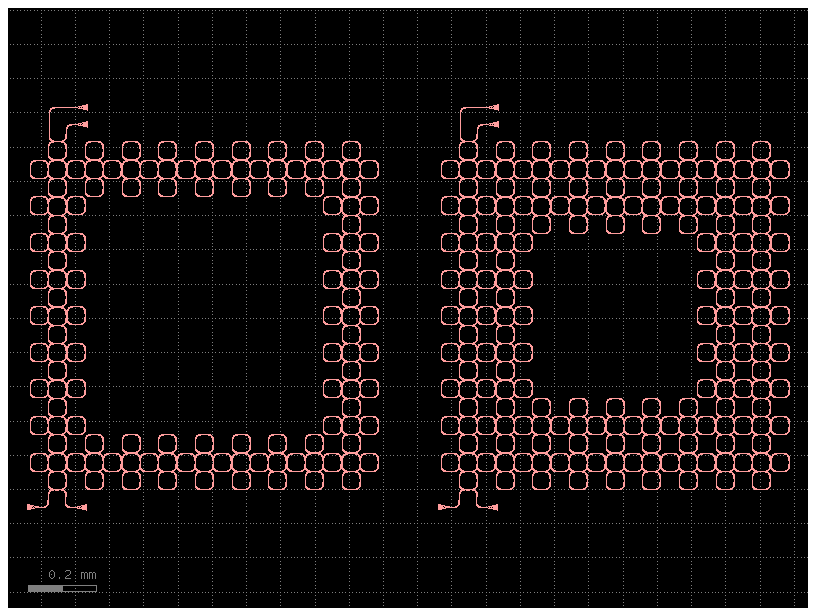

In [33]:
gf.clear_cache()
aqhe_ror = gf.Component("aqhe_ror")

x_shift = 1200

aqhe_ror << AQHE_ROR(20, 12, 0, 0.2, 1.3, x_shift, 0, 10, 1, 0.2, 0.2)
aqhe_ror << AQHE_ROR(20, 12, 0, 0.2, 1.3, 2*x_shift, 0, 10, 2, 0.2, 0.2)
aqhe_ror.show()
aqhe_ror.plot()